# Benchmark an Endpoint

Welcome to this tutorial on benchmarking an endpoint deployed on a SambaNova dedicated node!

If you don't already have an endpoint deployed, please follow one of the workflows described in the [README](./README.md) to deploy an endpoint before proceeding with this tutorial.

Also, please install the benchmarking requirements in the Python kernel used in this Jupyter notebook

`! pip install -r ../../benchmarking/requirements.txt`

## 1.  Imports

In [1]:
import sys
sys.version

'3.11.11 (main, Dec 11 2024, 10:28:39) [Clang 14.0.6 ]'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
import json
import os
import pprint
import getpass
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
benchmarking_dir = "../../benchmarking/"
sys.path.append(benchmarking_dir + "benchmarking_scripts")
sys.path.append(benchmarking_dir + "prompts")

from synthetic_performance_eval_script import *

## 2. Get endpoint info
To benchmark the endpoint, we will need to obtain some of its information. Note that this information can be obtained from your SambaNova representative.

#### Enter the endpoint url
Run the cell below and then enter the endpoint URL. This should be in the format of `https://my.env/v1/<endpoint_id>/chat/completions` 

In [ ]:
endpoint_url = input().strip()
if endpoint_url[-1] == "/":
    endpoint_url = endpoint_url[:-1]
os.environ["SAMBASTUDIO_URL"] = endpoint_url
endpoint_id = endpoint_url.split('/')[-3]
print("Benchmarking Endpoint:", endpoint_id)

#### Enter the endpoint API key

In [6]:
endpoint_key = getpass.getpass().strip()
if len(endpoint_key) > 0:
    os.environ["SAMBASTUDIO_API_KEY"] = endpoint_key
else:
    print("Please enter a valid key")

## 3. Automatically retrieve model list from endpoint (Optional)
Run this section only if you don't the have list of models on the endpoint. Note that running this section requires you to first follow the set up instructions given in the [README](./README.md)
#### Set up environment connector
The connector connects to the remote dedicated environment using the variables defined below

In [7]:
env_url = '/'.join(endpoint_url.split('/')[:3])
env_url

'https://sjc3-e8.sambanova.net'

In [8]:
print("Enter the env access key")
env_key = getpass.getpass().strip()
if len(env_key) > 0:
    os.environ["SAMBASTUDIO_ACCESS_KEY"] = env_key
else:
    print("Please enter a valid key")

Enter the env access key


In [9]:
env_tenant = "default"

In [10]:
from snsdk import SnSdk
sn_env = SnSdk(host_url=env_url, 
                   access_key=env_key, 
                   tenant_id=env_tenant)

#### Get model names in the endpoint

In [11]:
endpoint_info = sn_env.endpoint_info_by_id(endpoint_id)
endpoint_model_id = endpoint_info['targets'][0]["model"]
model_info = sn_env.model_info(endpoint_model_id, job_type="deploy")
model_constituents = [m["name"] for m in model_info["dependencies"]]
sorted(model_constituents)

['Meta-Llama-3.2-1B-Instruct', 'Meta-Llama-3.3-70B-Instruct']

#### Get target model names in the endpoint
Target model names generally differ from model names when the model is a speculative decoding pair

In [12]:
target_models = []
for constituent_name in model_constituents:    
    model_name = constituent_name

    # Check for speculative decoding
    constituent_info = sn_env.model_info(constituent_name, job_type="deploy")
    if 'target_model' in constituent_info['config']:
        target_name = constituent_info['config']['target_model']        
        if len(target_name) > 0:
            model_name = target_name
    target_models.append(model_name)
sorted(target_models)

['Meta-Llama-3.2-1B-Instruct', 'Meta-Llama-3.3-70B-Instruct']

## 4. Set up Model Configs for Benchmarking
Note that this section only currently supports a fraction of what the Benchmarking Kit is capable of. You may repurpose this section if you would like to benchmark images or run questions per second (qps).

#### Specify target models
If not automatically set in Step 3, set Target models as a python list

In [13]:
target_models = target_models #["Meta-Llama-3.3-70B-Instruct"]

#### Specify combinatorial inputs for benchmarking

In [14]:
input_tokens = [3900, 8000, 16000]
output_tokens = [100]
num_requests = [64]
concurrent_requests = [1, 2, 4, 8, 16, 32]

#### Automatically generate configs

In [15]:
model_configs_df = pd.DataFrame(columns=[
                "model_name",
                "input_tokens",
                "output_tokens",
                "num_requests",
                "concurrent_requests"
                ])
counter = 1
for target_model in target_models:
    for input_token in input_tokens:
        for output_token in output_tokens:
            for num_request in num_requests:
                for concurrent_request in concurrent_requests:
                    model_configs_df.loc[counter] = [
                                        target_model, 
                                        input_token,
                                        output_token,
                                        num_request,
                                        concurrent_request
                                    ]
                    counter += 1


#### Confirm model configs and delete any configs that you would rather exclude

In [16]:
model_configs_df

,model_name,input_tokens,output_tokens,num_requests,concurrent_requests
1,Meta-Llama-3.3-70B-Instruct,3900,100,64,1
2,Meta-Llama-3.3-70B-Instruct,3900,100,64,2
3,Meta-Llama-3.3-70B-Instruct,3900,100,64,4
4,Meta-Llama-3.3-70B-Instruct,3900,100,64,8
5,Meta-Llama-3.3-70B-Instruct,3900,100,64,16
6,Meta-Llama-3.3-70B-Instruct,3900,100,64,32
7,Meta-Llama-3.3-70B-Instruct,8000,100,64,1
8,Meta-Llama-3.3-70B-Instruct,8000,100,64,2
9,Meta-Llama-3.3-70B-Instruct,8000,100,64,4
10,Meta-Llama-3.3-70B-Instruct,8000,100,64,8


In [17]:
drop_rows = []
model_configs_df.drop(drop_rows, inplace=True)
model_configs_df

,model_name,input_tokens,output_tokens,num_requests,concurrent_requests
1,Meta-Llama-3.3-70B-Instruct,3900,100,64,1
2,Meta-Llama-3.3-70B-Instruct,3900,100,64,2
3,Meta-Llama-3.3-70B-Instruct,3900,100,64,4
4,Meta-Llama-3.3-70B-Instruct,3900,100,64,8
5,Meta-Llama-3.3-70B-Instruct,3900,100,64,16
6,Meta-Llama-3.3-70B-Instruct,3900,100,64,32
7,Meta-Llama-3.3-70B-Instruct,8000,100,64,1
8,Meta-Llama-3.3-70B-Instruct,8000,100,64,2
9,Meta-Llama-3.3-70B-Instruct,8000,100,64,4
10,Meta-Llama-3.3-70B-Instruct,8000,100,64,8


## 5. Run Benchmarking
We will run benchmarking with the configs now

#### Name the benchmarking run
Give the run a unique name so that the configs and results can be saved with that name. Please note that the name should be compatible with file system path naming rules.

In [25]:
run_name = "llama33_70b_sd_1b_short_studio_20250524_1"

#### Configure saving options
Saving makes it easy to re-run the model configs by skipping all the above sections

In [26]:
output_path = f"{benchmarking_dir}data/benchmarking_tracking_tests/"
config = {
    'model_configs_path': f'{output_path}model_configs_{run_name}.csv', # leave this as is
    'llm_api': 'sambastudio', # leave this as is
    'output_files_dir': f'{output_path}logs/output_files', # each run saved here
    'consolidated_results_dir': f'{output_path}consolidated_results', # consolidated xlsx saved here
    'timeout': 3600,
    'time_delay': 0, # between batches of concurrent requests
}

#### Save configs

In [20]:
with open(f"{output_path}config_{run_name}.yaml", "w") as f:
    yaml.dump(config, f, default_flow_style=False)
model_configs_df.to_csv(config["model_configs_path"], index=False)

#### Run configs

In [ ]:
run_benchmarking(config=config, benchmarking_dir=benchmarking_dir, run_name=run_name)

2025-05-26 21:46:22,204 [INFO] Running model_name Meta-Llama-3.3-70B-Instruct, input_tokens 3900, output_tokens 100, concurrent_requests 1, num_requests 64, multimodal_img_size na


Running Requests: 100%|██████████| 64/64 [00:55<00:00,  1.07it/s]

2025-05-26 21:47:19,107 [INFO] Tasks Executed!
2025-05-26 21:47:19,108 [INFO] Benchmarking results obtained for model Meta-Llama-3.3-70B-Instruct queried with the sambastudio API.
2025-05-26 21:47:19,132 [INFO] Building Client Metrics Summary for metric: client_ttft_s
2025-05-26 21:47:19,136 [INFO]     p5 = 0.5455
2025-05-26 21:47:19,137 [INFO]     p25 = 0.5811
2025-05-26 21:47:19,137 [INFO]     p50 = 0.6305
2025-05-26 21:47:19,137 [INFO]     p75 = 0.6884
2025-05-26 21:47:19,138 [INFO]     p90 = 0.765
2025-05-26 21:47:19,138 [INFO]     p95 = 0.8015
2025-05-26 21:47:19,138 [INFO]     p99 = 0.8075
2025-05-26 21:47:19,139 [INFO]     mean = 0.6445
2025-05-26 21:47:19,139 [INFO]     min = 0.5256
2025-05-26 21:47:19,140 [INFO]     max = 0.8122
2025-05-26 21:47:19,140 [INFO]     stddev = 0.0792
2025-05-26 21:47:19,140 [INFO] Building Client Metrics Summary for metric: client_end_to_end_latency_s
2025-05-26 21:47:19,141 [INFO]     p5 = 0.7536
2025-05-26 21:47:19,142 [INFO]     p25 = 0.7954
202

Running Requests:  91%|█████████ | 58/64 [00:36<00:03,  1.59it/s]

KeyboardInterrupt: 

Running Requests:  97%|█████████▋| 62/64 [00:38<00:01,  1.61it/s]

## 6. Compare with alternative provider

In [22]:
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [27]:
current_name = "Studio MP1"
alt_name = "Studio Old Bundle"

#### Read results from current run

In [28]:
current_file_path = os.path.join(config["consolidated_results_dir"], f'{run_name}.xlsx')
df_current = pd.read_excel(current_file_path, sheet_name='Sheet1')
df_current["provider"] = current_name
df_current.head()

,uuid,name,model,num_input_tokens,num_output_tokens,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size,provider
0,2e84da61-1b01-4fee-821d-cf4c25f04bde,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,Meta-Llama-3-2-1B-Instruct,3900,100,1,0.0360,0.0376,0.0413,0.0914,0.0928,0.1357,1049.0555,1792.5886,1812.4270,1770.7629,NaN,NaN,NaN,3934,100,0.2052,0.2940,0.5464,0.2584,0.4413,0.7747,246.5579,956.5870,1946.2699,1041.9840,218.6142,64,64,131.1685,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.0,Studio MP1
1,2baa865d-dfc9-43ba-97a4-5d35ce11c75d,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,Meta-Llama-3-2-1B-Instruct,3900,100,2,0.0365,0.0377,0.0401,0.0918,0.0935,0.1146,1287.6855,1779.9901,1810.0095,1769.3999,NaN,NaN,NaN,3934,100,0.1821,0.2398,0.3125,0.2396,0.2985,0.4070,715.8978,1848.0838,2671.1037,1754.4127,652.2000,64,64,391.3200,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.0,Studio MP1
2,686e0579-f094-4682-9281-f3e277a158b0,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,Meta-Llama-3-2-1B-Instruct,3900,100,4,0.0368,0.0659,0.1184,0.0919,0.1279,0.2167,1007.3021,1601.9726,1819.9976,1611.6271,NaN,NaN,NaN,3934,100,0.1969,0.3207,0.4366,0.2573,0.3796,0.5018,690.2778,1679.5056,2091.6764,1651.0233,1057.0480,64,64,634.2288,0,{},"[1, 3, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, ...","[1, 4, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, ...",2.0,Studio MP1
3,239d9ed9-ad3d-437e-8da8-c3c58ebeb71c,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,Meta-Llama-3-2-1B-Instruct,3900,100,8,0.0378,0.1170,0.2289,0.0923,0.1847,0.3414,879.8475,1457.1631,1816.4785,1434.1261,NaN,NaN,NaN,3934,100,0.2296,0.3576,0.6381,0.2925,0.4238,0.7341,586.4032,1527.4935,1926.1359,1475.7549,1474.8953,64,64,884.9372,0,{},"[1, 4, 3, 4, 4, 3, 4, 4, 2, 3, 5, 3, 4, 3, 4, ...","[1, 4, 4, 4, 4, 4, 4, 4, 2, 4, 8, 4, 4, 4, 4, ...",4.0,Studio MP1
4,c478cb8a-da0a-4c46-bf0a-cf23a883418f,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,Meta-Llama-3-2-1B-Instruct,3900,100,16,0.0667,0.2294,2.2081,0.1293,0.3075,2.3393,754.8951,1242.1843,1582.0808,1153.1320,NaN,NaN,NaN,3934,100,0.2921,0.6965,3.1672,0.3530,0.7931,3.2917,746.1742,1240.8125,1694.8997,1170.6887,1189.9645,64,64,713.9787,0,{},"[2, 4, 7, 9, 7, 8, 8, 7, 9, 3]","[2, 4, 8, 16, 8, 8, 8, 8, 16, 4]",NaN,Studio MP1


#### Read results from alternative source

In [29]:
# df_alt = pd.read_excel('~/Downloads/Master_Benchmarking_Sheet.xlsx', sheet_name='Sheet1',  header=0, index_col=[0, 1, 2, 3]).reset_index()
# df_alt = df_alt[df_alt["model"].isin([t.replace('.', '-') for t in target_models])]
# df_alt["provider"] = alt_name
# df_alt.head()
#alt_run_name = "llama33_70b-ss-8-16-32k_cloud_dedicated_20250521_2"
#alt_run_name = "llama33_70b_cloud_shared_20250522_1"
alt_run_name = "qwen_llama_salesforce_20250522_1"
current_file_path = os.path.join(config["consolidated_results_dir"], f'{alt_run_name}.xlsx')
df_alt = pd.read_excel(current_file_path, sheet_name='Sheet1')
df_alt = df_alt[df_alt["model"].isin([t.replace('.', '-') for t in target_models])]
df_alt["provider"] = alt_name
df_alt.head()

,uuid,name,model,num_input_tokens,num_output_tokens,num_concurrent_requests,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size,provider
0,b0dc33a7-3c06-4b21-bdd1-a7b24d7a69e4,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,Meta-Llama-3-3-70B-Instruct,3900,100,1,0.3435,0.3443,1.1247,1.0113,1.0129,1.8714,132.5920,148.0838,148.3224,147.8076,NaN,NaN,NaN,3934,100,0.4940,0.5818,1.4352,1.1476,1.2421,2.1812,134.0562,150.0307,175.1549,153.1611,78.5047,64,64,47.1028,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,Studio Old Bundle
1,a1401871-83c2-4ba1-ab76-536865a91164,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,Meta-Llama-3-3-70B-Instruct,3900,100,2,0.3431,0.3441,0.3470,1.0109,1.0125,1.0155,147.8141,148.1315,148.3192,148.1155,NaN,NaN,NaN,3934,100,0.4976,1.5428,1.6533,1.1725,2.2102,2.2753,145.8577,150.0439,182.0759,152.9585,90.2422,64,64,54.1453,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,Studio Old Bundle
2,63028200-1581-4011-85a3-a93d6a574b4e,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,Meta-Llama-3-3-70B-Instruct,3900,100,4,0.3437,1.1957,1.7569,1.0118,1.8956,2.5508,124.6926,141.3916,148.3314,142.2873,NaN,NaN,NaN,3934,100,0.5056,2.4090,3.0946,1.1713,3.1042,3.8325,125.7833,143.2485,156.0484,145.0140,126.8267,64,64,76.0960,0,{},"[1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, ...","[1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, ...",4,Studio Old Bundle
3,b863f438-547a-4bff-be0c-e7ad43ff9d54,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,Meta-Llama-3-3-70B-Instruct,3900,100,8,0.3445,2.3482,2.9059,1.0127,3.0523,3.6687,129.7717,140.5937,148.3009,140.3219,NaN,NaN,NaN,3934,100,0.5032,3.5690,4.2163,1.1732,4.2667,4.9716,128.6845,142.5900,170.8632,145.9383,183.4683,64,64,110.0810,0,{},"[1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7, 1, 7]","[1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8, 1, 8]",8,Studio Old Bundle
4,2a79814a-5e85-4888-baa6-7937fd471ae5,synthetic_0_Meta-Llama-3-3-70B-Instruct_3900_1...,Meta-Llama-3-3-70B-Instruct,3900,100,16,0.3443,4.6500,5.3667,1.0127,5.4840,6.2712,109.4521,118.6958,148.1820,117.2565,NaN,NaN,NaN,3934,100,0.5238,5.9097,6.8493,1.1896,6.7408,7.6154,108.6299,119.6373,150.2173,119.5068,229.9245,64,64,137.9547,0,{},"[1, 15, 1, 15, 1, 15, 1, 15]","[1, 16, 1, 16, 1, 16, 1, 16]",16,Studio Old Bundle


#### Combine dataframes

In [30]:
df_current.shape, df_alt.shape

((36, 41), (18, 41))

In [31]:
common_columns = list(set(df_current.columns) & set(df_alt.columns)) # get intersection
common_columns = [c for c in df_current.columns if c in common_columns] # reorder
len(common_columns)

41

In [32]:
first_columns = ['provider','model','num_input_tokens','num_output_tokens','num_concurrent_requests']
following_columns = [column for column in common_columns if column not in first_columns]
results = pd.concat([
        df_current,
        df_alt
    ], axis=0
)[first_columns + following_columns]
results.head()

,provider,model,num_input_tokens,num_output_tokens,num_concurrent_requests,uuid,name,server_ttft_s_min,server_ttft_s_p50,server_ttft_s_max,server_end_to_end_latency_s_min,server_end_to_end_latency_s_p50,server_end_to_end_latency_s_max,server_output_token_per_s_min,server_output_token_per_s_p50,server_output_token_per_s_max,server_output_token_per_s_mean,acceptance_rate_min,acceptance_rate_p50,acceptance_rate_max,server_number_input_tokens_p50,server_number_output_tokens_p50,client_ttft_s_min,client_ttft_s_p50,client_ttft_s_max,client_end_to_end_latency_s_min,client_end_to_end_latency_s_p50,client_end_to_end_latency_s_max,client_output_token_per_s_min,client_output_token_per_s_p50,client_output_token_per_s_max,client_output_token_per_s_mean,client_mean_output_token_per_s,num_requests_started,num_completed_requests,num_completed_requests_per_min,number_errors,error_code_frequency,requests_grouping,requests_batching,representative_batch_size
0,Studio MP1,Meta-Llama-3-2-1B-Instruct,3900,100,1,2e84da61-1b01-4fee-821d-cf4c25f04bde,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,0.0360,0.0376,0.0413,0.0914,0.0928,0.1357,1049.0555,1792.5886,1812.4270,1770.7629,NaN,NaN,NaN,3934,100,0.2052,0.2940,0.5464,0.2584,0.4413,0.7747,246.5579,956.5870,1946.2699,1041.9840,218.6142,64,64,131.1685,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.0
1,Studio MP1,Meta-Llama-3-2-1B-Instruct,3900,100,2,2baa865d-dfc9-43ba-97a4-5d35ce11c75d,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,0.0365,0.0377,0.0401,0.0918,0.0935,0.1146,1287.6855,1779.9901,1810.0095,1769.3999,NaN,NaN,NaN,3934,100,0.1821,0.2398,0.3125,0.2396,0.2985,0.4070,715.8978,1848.0838,2671.1037,1754.4127,652.2000,64,64,391.3200,0,{},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.0
2,Studio MP1,Meta-Llama-3-2-1B-Instruct,3900,100,4,686e0579-f094-4682-9281-f3e277a158b0,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,0.0368,0.0659,0.1184,0.0919,0.1279,0.2167,1007.3021,1601.9726,1819.9976,1611.6271,NaN,NaN,NaN,3934,100,0.1969,0.3207,0.4366,0.2573,0.3796,0.5018,690.2778,1679.5056,2091.6764,1651.0233,1057.0480,64,64,634.2288,0,{},"[1, 3, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, ...","[1, 4, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, ...",2.0
3,Studio MP1,Meta-Llama-3-2-1B-Instruct,3900,100,8,239d9ed9-ad3d-437e-8da8-c3c58ebeb71c,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,0.0378,0.1170,0.2289,0.0923,0.1847,0.3414,879.8475,1457.1631,1816.4785,1434.1261,NaN,NaN,NaN,3934,100,0.2296,0.3576,0.6381,0.2925,0.4238,0.7341,586.4032,1527.4935,1926.1359,1475.7549,1474.8953,64,64,884.9372,0,{},"[1, 4, 3, 4, 4, 3, 4, 4, 2, 3, 5, 3, 4, 3, 4, ...","[1, 4, 4, 4, 4, 4, 4, 4, 2, 4, 8, 4, 4, 4, 4, ...",4.0
4,Studio MP1,Meta-Llama-3-2-1B-Instruct,3900,100,16,c478cb8a-da0a-4c46-bf0a-cf23a883418f,synthetic_0_Meta-Llama-3-2-1B-Instruct_3900_10...,0.0667,0.2294,2.2081,0.1293,0.3075,2.3393,754.8951,1242.1843,1582.0808,1153.1320,NaN,NaN,NaN,3934,100,0.2921,0.6965,3.1672,0.3530,0.7931,3.2917,746.1742,1240.8125,1694.8997,1170.6887,1189.9645,64,64,713.9787,0,{},"[2, 4, 7, 9, 7, 8, 8, 7, 9, 3]","[2, 4, 8, 16, 8, 8, 8, 8, 16, 4]",NaN


In [33]:
results["server_throughput"] = results["server_output_token_per_s_p50"] * results["representative_batch_size"]
results["server_total_latency"] =  results["num_completed_requests"]*60/results["num_completed_requests_per_min"]

### Plot benchmarking charts among providers

You may change the pallette color based on the color that better identifies each provider. You can take the [following link](https://seaborn.pydata.org/tutorial/color_palettes.html) as reference. Also, you will need to update the suptitle to reflect the model you're showing and any other detail. 

<Figure size 640x480 with 0 Axes>

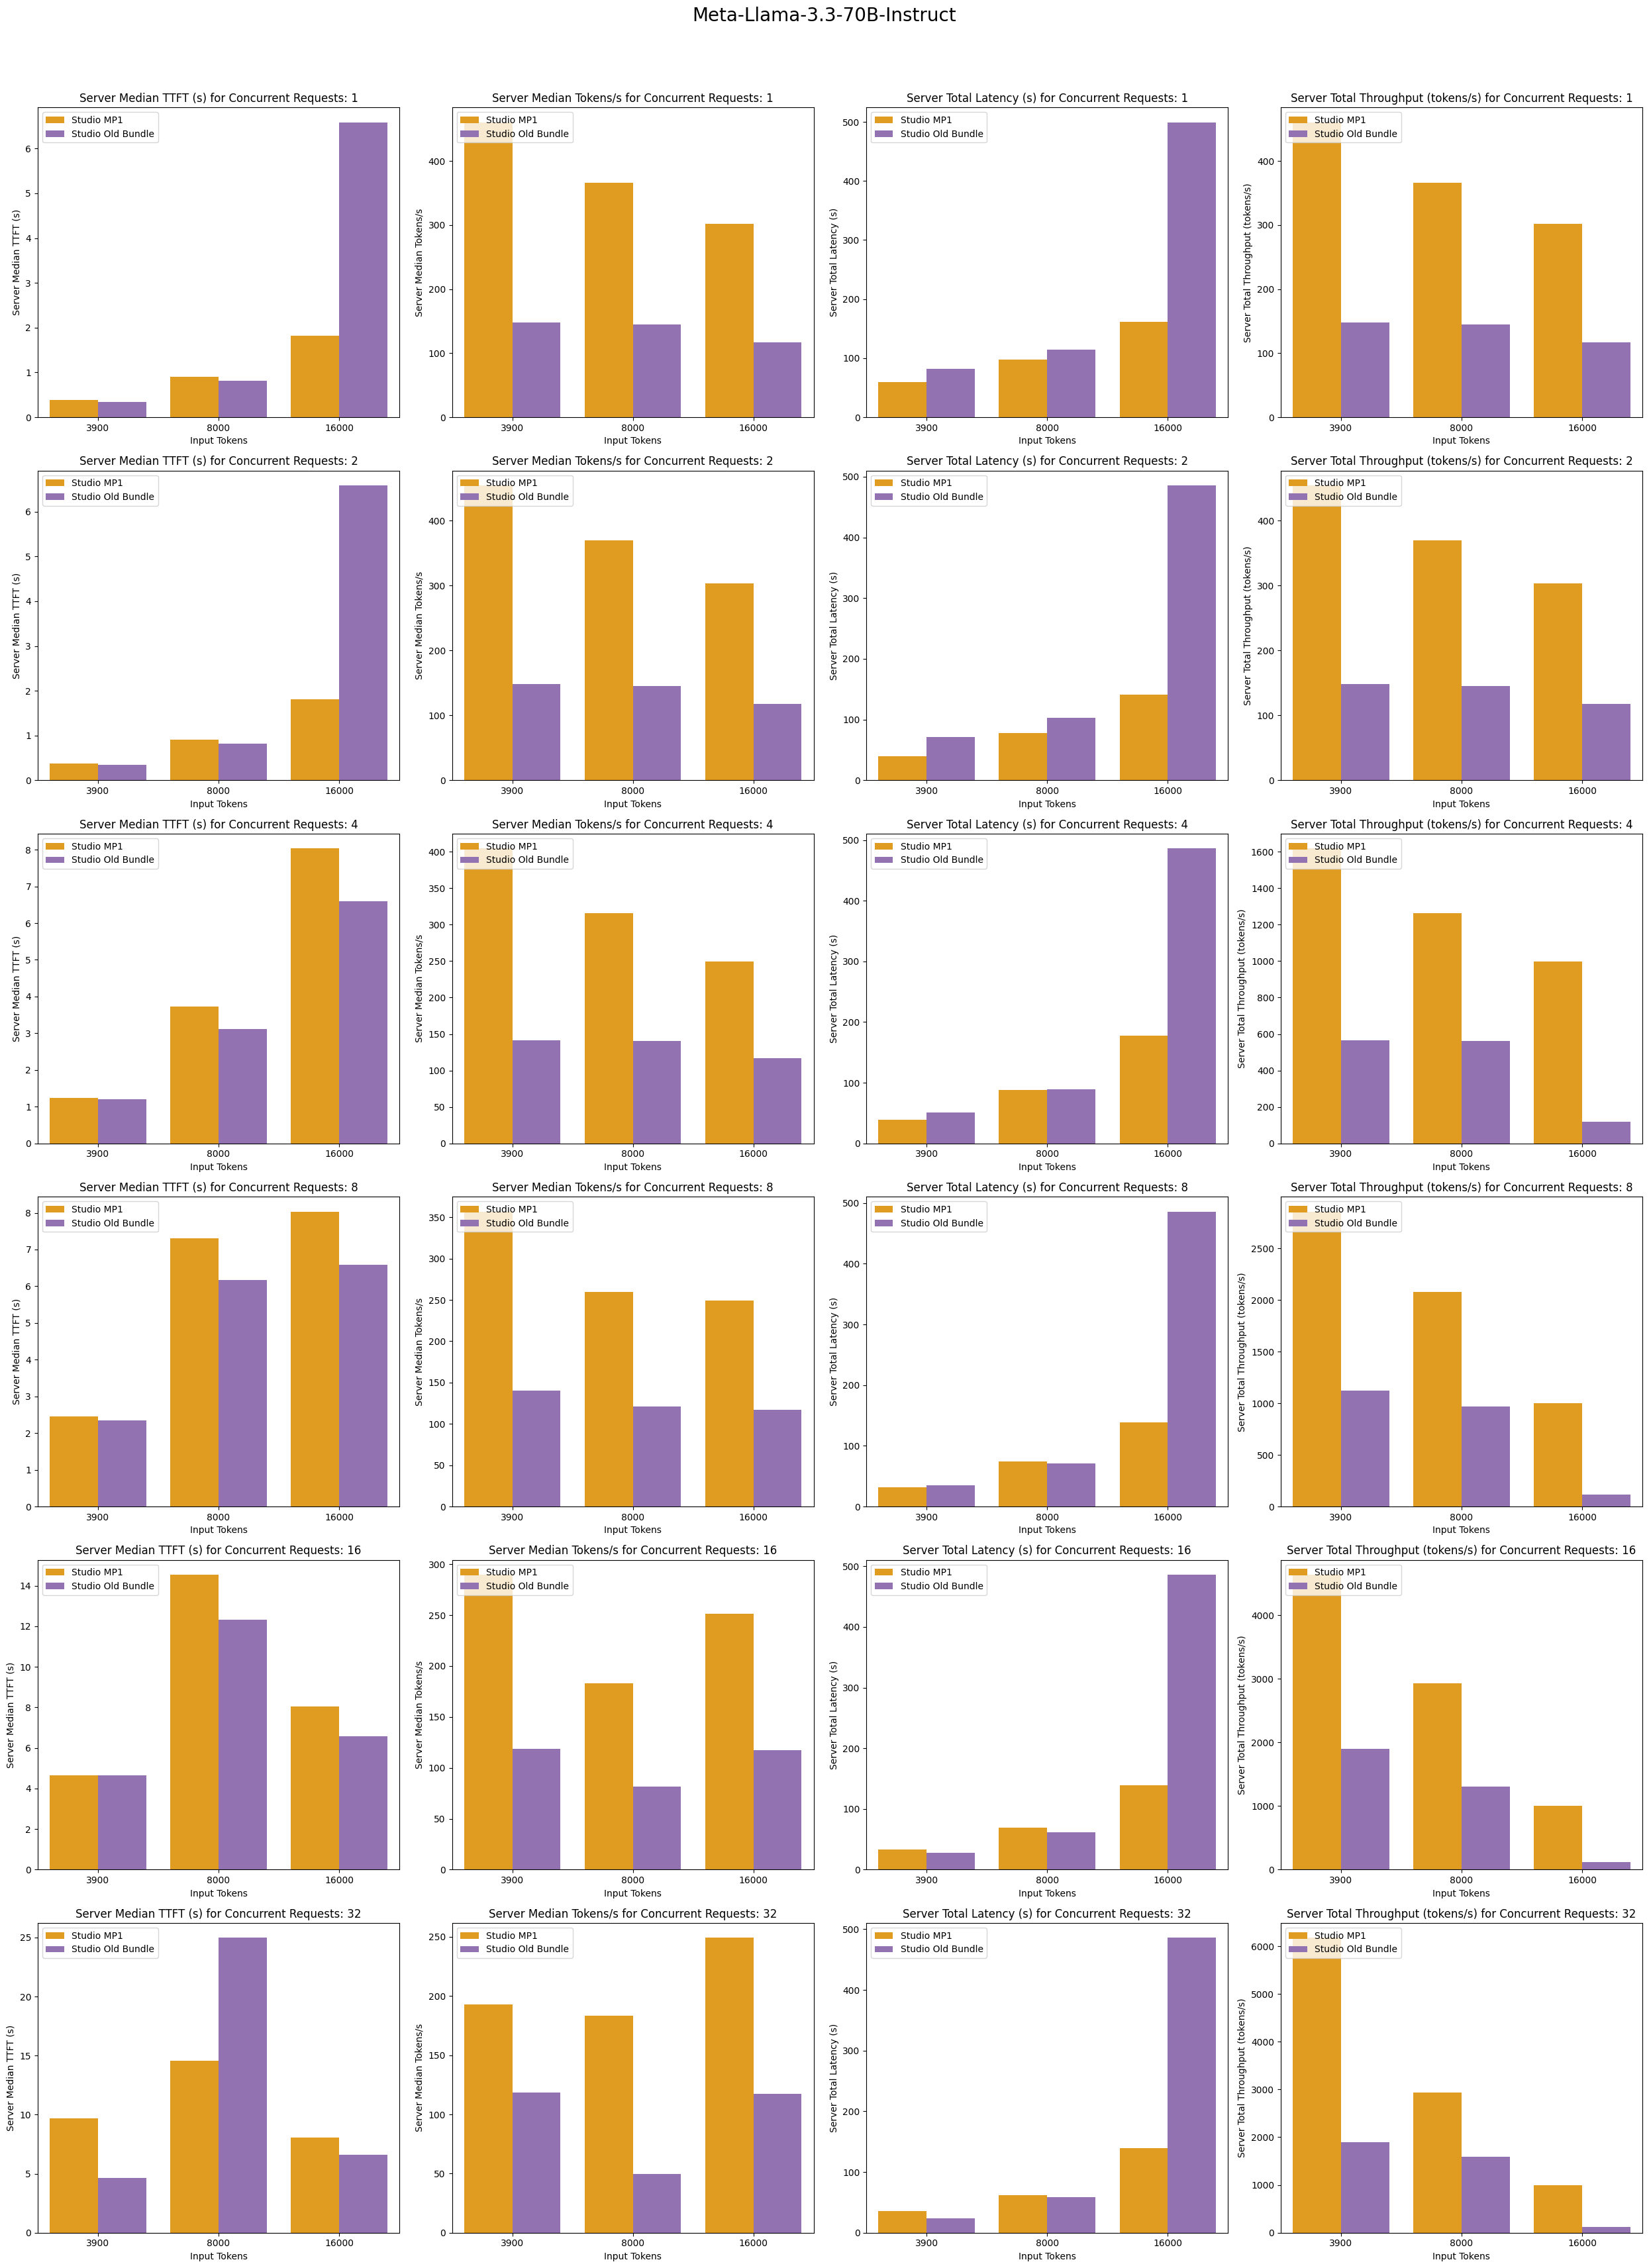

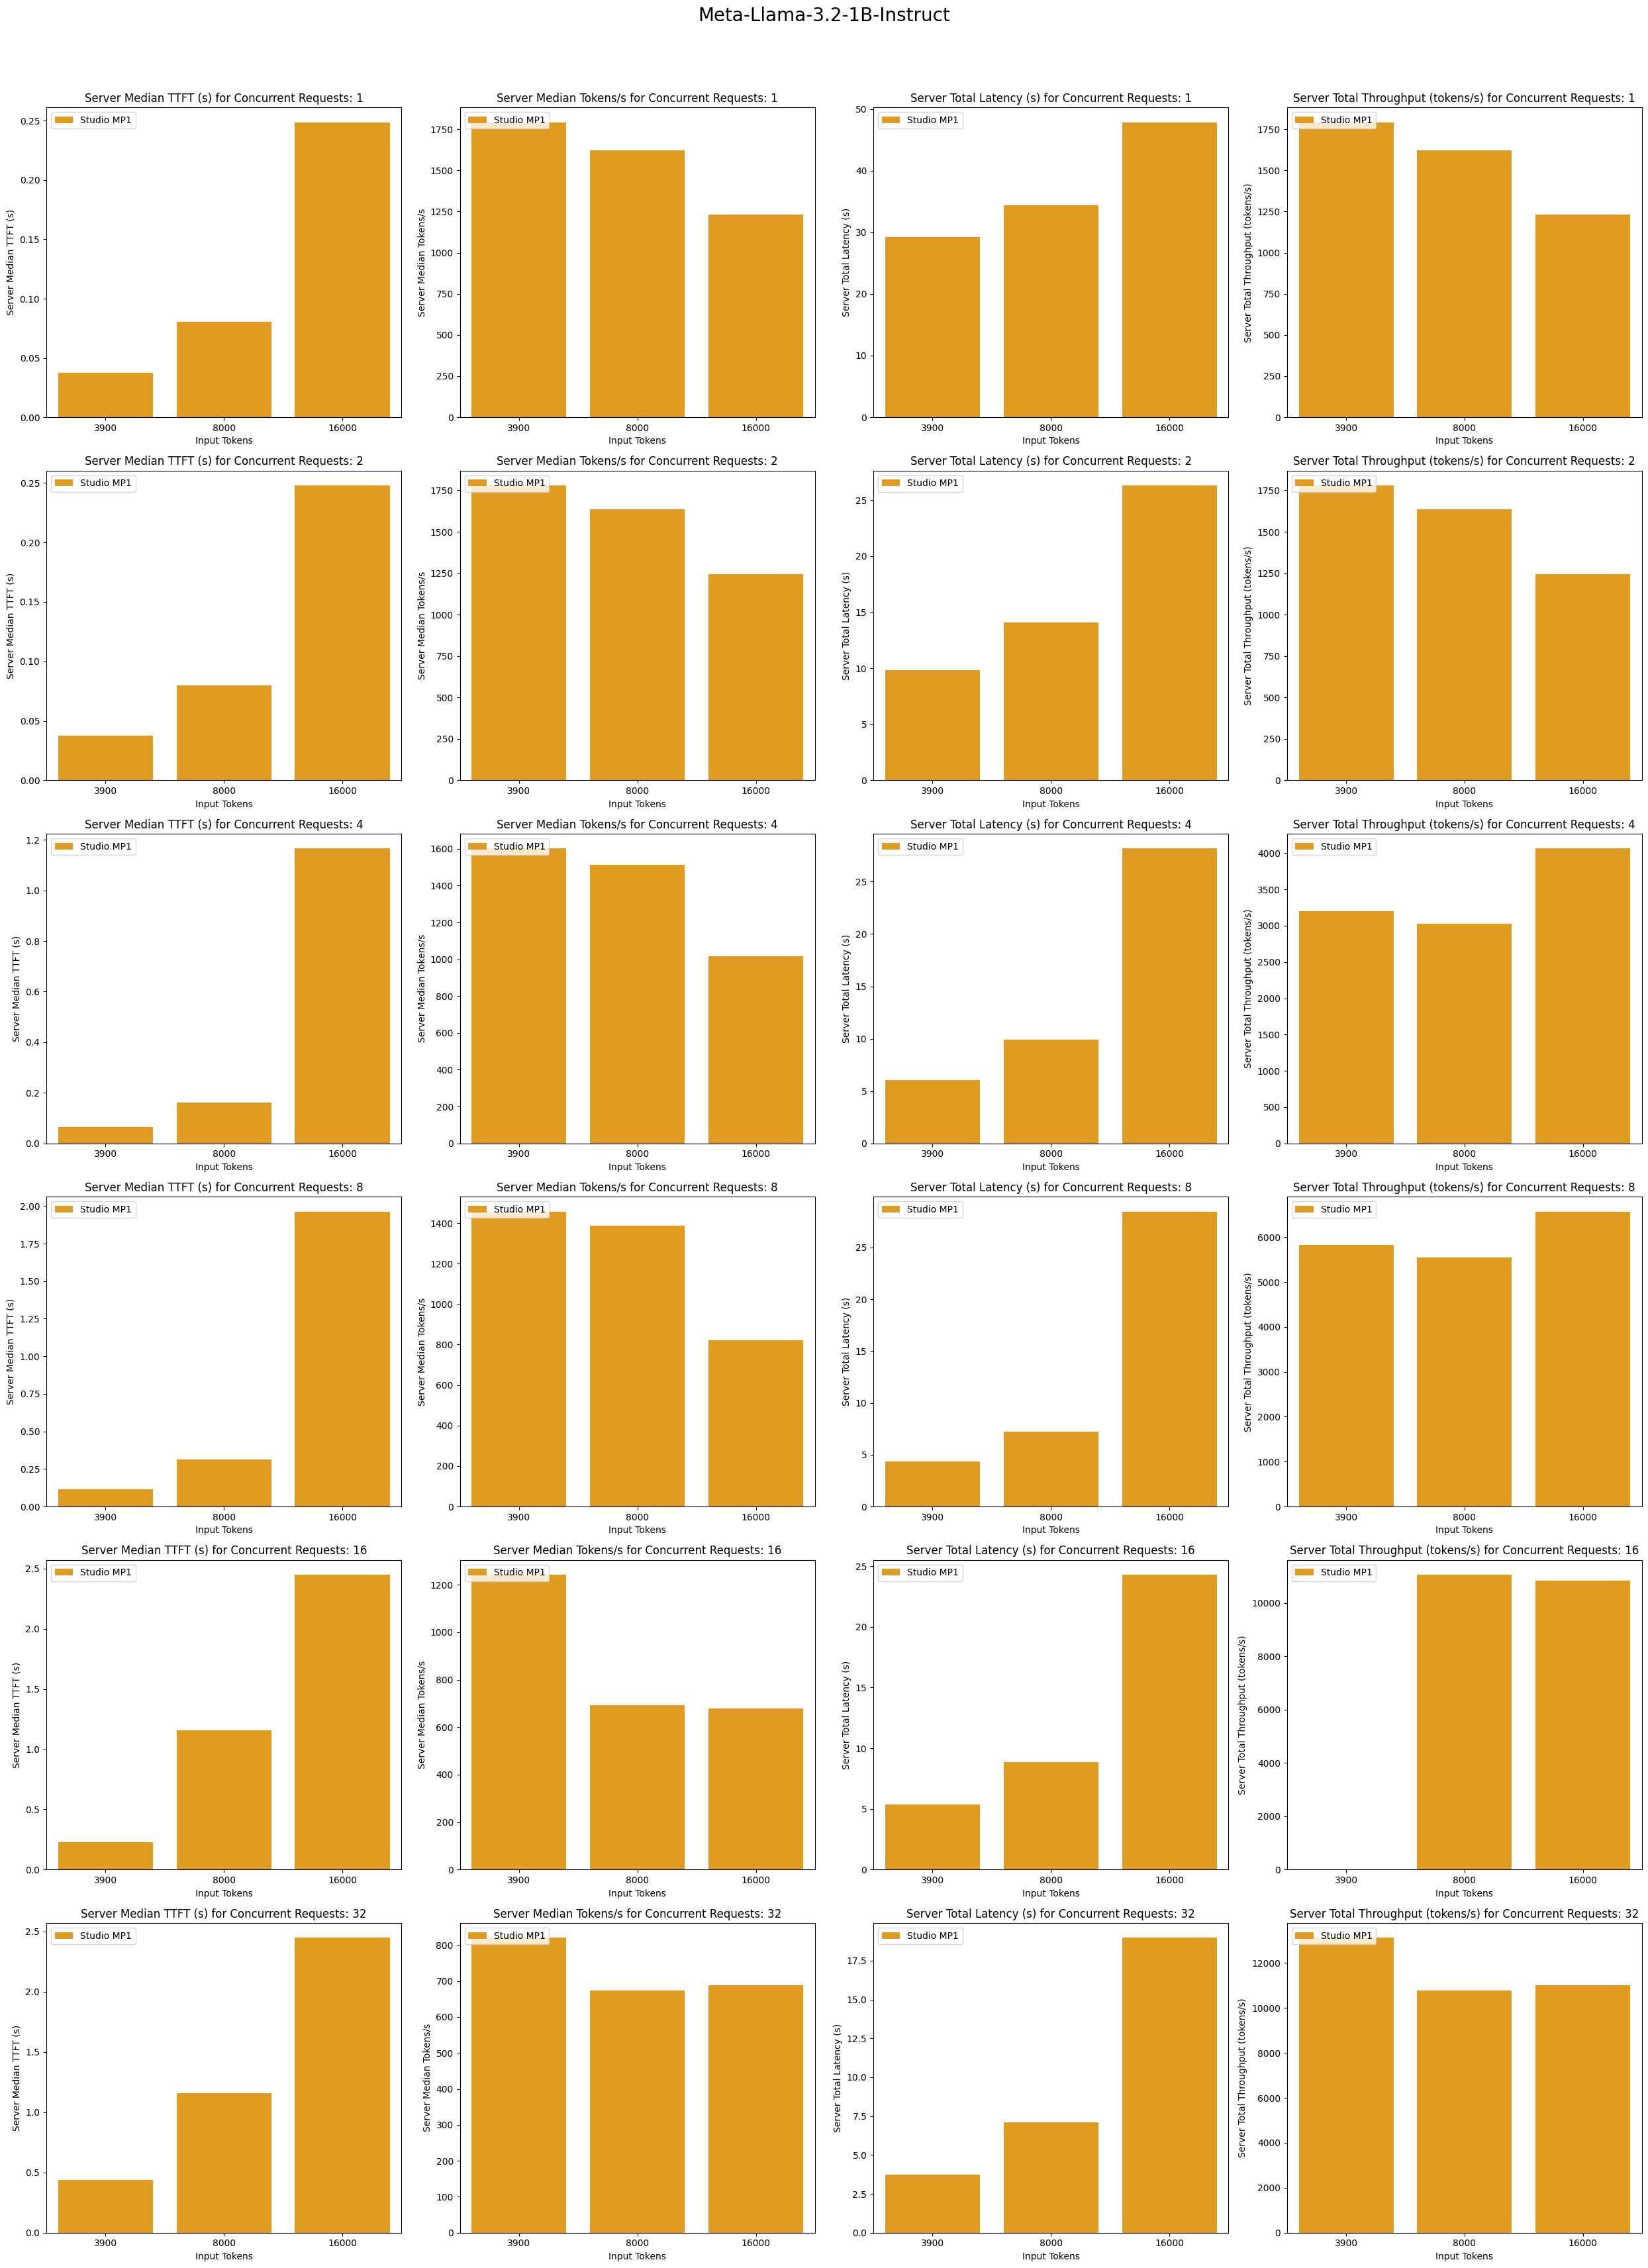

In [34]:
%matplotlib inline

# Pallette for the providers, change colors and provider names as needed
palette = {current_name: 'orange', alt_name: 'tab:purple'}

fields = {
    "Server Median TTFT (s)": "server_ttft_s_p50",
    "Server Median Tokens/s": "server_output_token_per_s_p50",
    "Server Total Latency (s)": "server_total_latency",
    "Server Total Throughput (tokens/s)": "server_throughput",
}

# Get unique concurrent values
concurrent_values = results['num_concurrent_requests'].unique()
concurrent_values.sort()

plt.clf()
for target_model in target_models:
    # Set up the figure and axes
    fig, axes = plt.subplots(len(concurrent_values), len(fields), figsize=(25, 6 * len(concurrent_values)), sharex=False)
    fig.suptitle(target_model, fontsize=20)
    for i, concurrent in enumerate(concurrent_values):
        subset = results[results['num_concurrent_requests'] == concurrent]
        subset = subset[subset['model'] == target_model.replace('.', '-')]        
        for j, field in enumerate(fields.keys()):
            ax = axes[i, j]                
            sns.barplot(data=subset, x='num_input_tokens', y=fields[field], hue='provider', ax=ax, palette=palette, errorbar=None)
            ax.set_title(f'{field} for Concurrent Requests: {concurrent}')
            ax.set_xlabel('Input Tokens')
            ax.set_ylabel(field)    
            ax.legend(loc=2)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()